### HOG + SVM

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive	sample_data


In [0]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from skimage import io
from skimage.color import rgb2gray
import pandas as pd
from skimage.transform import resize
import skimage
from skimage import data
from skimage.draw import rectangle_perimeter
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
!ls ./gdrive/'My Drive'/cv

1239.webm  ppl_1.JPG		    rtsd-d2-gt.tar.lzma
1357.webm  rtsd-d1-frames.tar.lzma  rtsd-d3-frames.tar.lzma
1418.webm  rtsd-d1-gt.tar.lzma	    rtsd-d3-gt.tar.lzma
GTSRB	   rtsd-d2-frames.tar.lzma


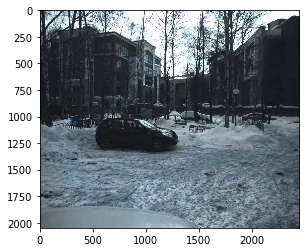

In [0]:
cap = cv2.VideoCapture('./gdrive/My Drive/cv/1357.webm')
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
i = 0 
# Read until video is completed
while(cap.isOpened()) and i < 1:
  # Capture frame-by-frame
  ret, frame = cap.read()
  i +=1
  if ret == True:
    # Display the resulting frame
    plt.imshow(frame)
 
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
 
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [0]:
import tarfile
tar = tarfile.open("./gdrive/My Drive/cv/rtsd-d1-frames.tar.lzma")
tar.extractall()
tar.close()

In [0]:
!ls /content/rtsd-d3-frames/train

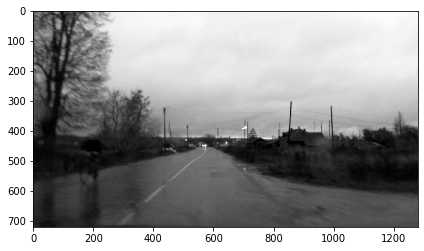

In [7]:
pic = io.imread('/content/rtsd-d3-frames/train/autosave10_10_2012_07_56_45_2.jpg')
pic = rgb2gray(pic)
io.imshow(pic)

In [0]:
tar = tarfile.open("./gdrive/My Drive/cv/rtsd-d1-gt.tar.lzma")
tar.extractall()
tar.close()

In [9]:
!ls /content/rtsd-d1-gt/danger

test_gt.csv  train_gt.csv


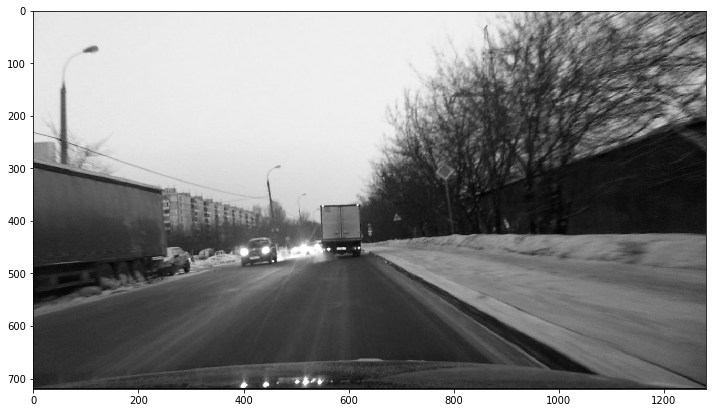

In [11]:
pic = io.imread('/content/rtsd-d3-frames/train/autosave01_02_2012_09_13_36.jpg')
pic = rgb2gray(pic)
plt.figure(figsize=(10,10))
io.imshow(pic) #/content/rtsd-d1-frames/test/autosave21_01_2013_12_34_35_1.jpg

In [0]:
annotation = pd.read_csv('/content/rtsd-d1-gt/danger/train_gt.csv')

In [0]:
annotation_test = pd.read_csv('/content/rtsd-d1-gt/danger/test_gt.csv')

In [15]:
annotation_test.head(5)

,filename,x_from,y_from,width,height,sign_class
0,autosave21_01_2013_12_38_13_2.jpg,403,351,21,19,1_25
1,autosave21_01_2013_12_38_13_2.jpg,798,333,22,21,1_25
2,autosave21_01_2013_12_38_20_1.jpg,376,343,28,24,1_25
3,autosave21_01_2013_12_41_10_2.jpg,834,295,36,36,1_12_2
4,autosave21_01_2013_12_46_31_2.jpg,790,340,23,23,1_17


In [16]:
annotation.head(5)

,filename,x_from,y_from,width,height,sign_class
0,autosave01_02_2012_09_13_36.jpg,684,384,17,17,1_23
1,autosave01_02_2012_09_13_42.jpg,698,331,18,18,1_17
2,autosave01_02_2012_09_13_42.jpg,700,352,18,17,1_23
3,autosave01_02_2012_09_13_43.jpg,746,291,25,26,1_17
4,autosave01_02_2012_09_13_43.jpg,749,320,26,24,1_23


In [17]:
len(annotation.values)

1594

In [18]:
!ls /content/rtsd-d1-frames/train/

ls: cannot access '/content/rtsd-d1-frames/train/': No such file or directory


In [0]:
import glob
from os.path import join
import numpy as np

XML_PATH = '/content/rtsd-d1-gt/danger/'
TRAIN_PATH = '/content/rtsd-d1-frames/train/'
TEST_PATH = '/content/rtsd-d1-frames/test/'

def _bbox_to_np(str_box_im):
    rect = np.array([[str_box_im[1], str_box_im[1]+str_box_im[3]], 
                 [str_box_im[2], str_box_im[2]+str_box_im[4]]])  
    return rect.astype(int)

def _read_annotation(annotation):
    ann = {}
    for str_ in annotation:
      if str_[0] not in ann.keys():
        ann[str_[0]] = [_bbox_to_np(str_)]
      else:
        ann[str_[0]].append(_bbox_to_np(str_))
    return ann

def _get_train(annotation):
    ann_dict =  _read_annotation(annotation)
    res = []
    k=0
    for i in ann_dict.keys():
        pic = io.imread(TRAIN_PATH+i)
        pic = pic = rgb2gray(pic)
        res.append([pic,ann_dict[i]])
        k +=1
        if k >600:
          break
    return res    
    
def _get_test(annotation):
    ann_dict =  _read_annotation(annotation)
    res = []
    k=0
    for i in ann_dict.keys():
        pic = io.imread(TEST_PATH+i)
        pic = pic = rgb2gray(pic)
        res.append([pic,ann_dict[i]])
        k +=1
        if k >600:
          break
    return res   

def get_train_sample(truncate=3000, step=10):
    return [_get_pair(i) for i in range(0, truncate, step)]

def get_test_sample(truncate=1000, step=100):
    return [_get_pair(i + TEST_STARTS_WITH) 
            for i in range(0, truncate, step)]
def get_patch(image, bbox):
    xmin = max(0, bbox[1, 0])
    xmax = bbox[1, 1]
    ymin = max(0, bbox[0, 0])
    ymax = bbox[0, 1]
    return image[xmin:xmax, ymin:ymax]

In [6]:
print(_read_annotation(annotation.values)['autosave01_02_2012_09_13_43.jpg'])

[array([[746, 771],
       [291, 317]]), array([[749, 775],
       [320, 344]])]


In [0]:
test = _get_test(annotation_test.values)

In [0]:
train = _get_train(annotation.values)

In [44]:
len(train)

601

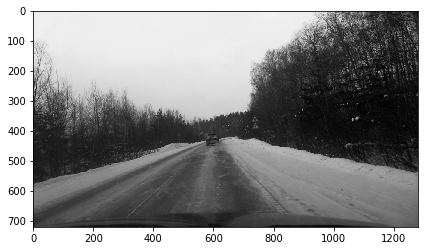

In [45]:
io.imshow(train[100][0])

In [0]:
print(train[204])

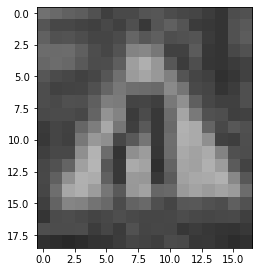

In [46]:
plt.figure(figsize=[10, 5])
for i in range(len(train[105][1])):
    plt.subplot(1, 3, i+1)
    io.imshow(get_patch(train[3][0], train[3][1][i]))

In [0]:
from matplotlib import cm
def plot_frame(train_sample, c=None):
    plt.figure(figsize=[12, 10])
    plt.imshow(train_sample[0], cmap=cm.gray)
    for bbox in train_sample[1]:
        plt.plot(*rectangle_perimeter(bbox[:, 0], bbox[:, 1]), c=c)
    plt.xlim([0, train_sample[0].shape[1]])
    plt.ylim([train_sample[0].shape[0], 0])

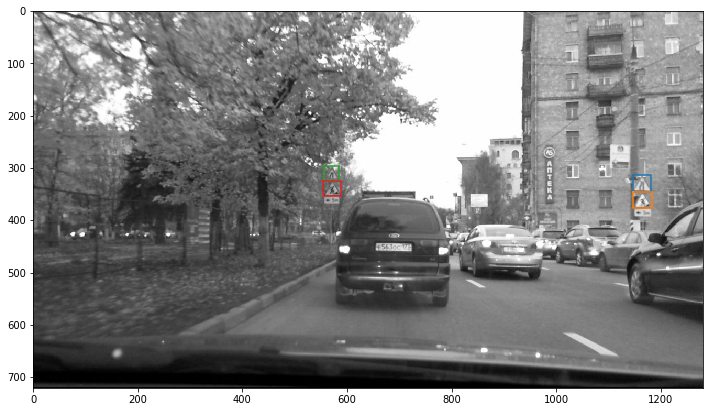

In [50]:
plot_frame(test[11])

In [9]:
import skimage
skimage.__version__

'0.15.0'

In [0]:
patches_pos = []
for bboxes in train:
    for bbox in bboxes[1]:
        patch = get_patch(bboxes[0], bbox)
        patches_pos.append(resize(patch, [32, 32]))

In [0]:
def get_random_patch(image, size_x, size_y):
    x_0 = np.random.randint(image.shape[0] - size_x)
    y_0 = np.random.randint(image.shape[1] - size_y)
#     print(x_0, y_0)
    return image[x_0 : x_0 + size_x,
                 y_0 : y_0 + size_y
                ]

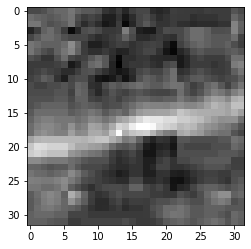

In [54]:
plt.imshow(get_random_patch(train[0][0], 32, 32), cmap=cm.gray)

In [12]:
patches_neg = []
for sample in train:
    rnd_patches = [get_random_patch(sample[0], 32, 32)
                   for i in range(16)]
    patches_neg.extend(rnd_patches)
print(len(patches_neg))

9616


In [14]:
sample_patch = patches_neg[0]
sample_patch.shape

(32, 32)

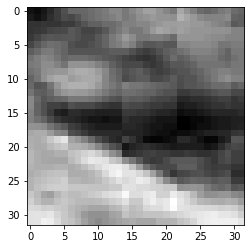

In [59]:
plt.imshow(sample_patch, cmap=cm.gray)

In [0]:
hog_res = hog(sample_patch)

In [0]:
X = [hog(patch) for patch in patches_pos + patches_neg]

In [17]:
X = np.array(X)
print(X.shape)

(10338, 324)


In [18]:
y = np.concatenate([np.ones(len(patches_pos)),
                    np.zeros(len(patches_neg)),
                   ])
print(y.shape)
print(y)

(10338,)
[1. 1. 1. ... 0. 0. 0.]


In [0]:
clf = LinearSVC()
y_pred = cross_val_predict(clf, X, y, cv=KFold(5, shuffle=True))

In [20]:
accuracy_score(y, y_pred)

0.9973882762623332

In [21]:
confusion_matrix(y, y_pred)

array([[9607,    9],
       [  18,  704]])

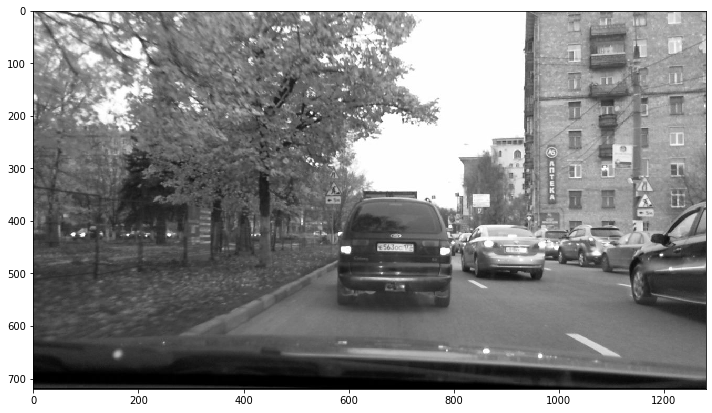

In [22]:
test_sample = test[11][0]
plt.figure(figsize=[10, 7])
io.imshow(test_sample)

In [23]:
test_sample.shape

(720, 1280)

In [24]:
test_sample.shape

(720, 1280)

In [25]:
clf = LinearSVC(C = 0.01)
clf.fit(X, y)

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [26]:
test_sample = io.imread('./gdrive/My Drive/cv/ppl_1.JPG')
test_sample = rgb2gray(test_sample)
plt.figure(figsize=[10, 7])
#io.imshow(test_sample)

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [27]:
step_x = 5
step_y = 5
test_bboxes = []
for x_0 in range(0, test_sample.shape[0] - 32, step_x):
    print(x_0, end=',')
    for y_0 in range(0, test_sample.shape[1]- 32, step_y):
        test_patch = test_sample[x_0:x_0+32, y_0:y_0+32]
        if clf.predict(hog(test_patch)[None, :]) == 1:
            test_bboxes.append(
                np.array([[y_0, y_0+32],
                            [x_0, x_0+32],
                          ])
            )

0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245,250,255,260,265,270,275,280,285,290,295,300,305,310,315,320,325,330,335,340,345,350,355,360,365,370,375,380,385,390,395,400,405,410,415,420,425,430,435,440,445,450,455,460,465,470,475,480,485,490,495,500,505,510,515,520,525,530,535,540,545,550,555,560,565,570,575,580,585,590,595,600,605,610,615,620,625,630,635,640,645,650,655,660,665,670,675,680,685,690,695,700,705,710,715,720,725,730,735,740,745,750,755,760,765,770,775,780,785,790,795,800,805,810,815,820,825,830,835,840,845,850,855,860,865,870,875,

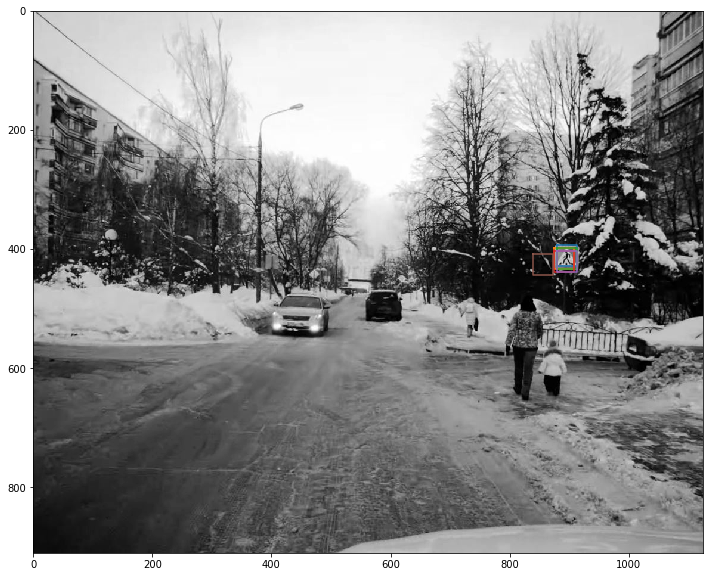

In [28]:
plot_frame([test_sample, test_bboxes])

In [76]:
test_sample.shape

(910, 1124)

### Attempt to make non-maxima supression

In [0]:
bbb = []
for box in test_bboxes:
  x1 = box[0,0]
  y1 = box[1, 1]
  x2 = box[0, 1]
  y2 = box[1, 0]
  bbb.append((x1, y1, x2, y2))
bbb = np.array(bbb)

In [28]:
bbb

array([[880, 427, 912, 395],
       [875, 432, 907, 400],
       [880, 432, 912, 400],
       [875, 437, 907, 405],
       [880, 437, 912, 405],
       [840, 442, 872, 410]])

In [145]:
bbb[:, 0]

array([880, 875, 880, 875, 880, 840])

In [135]:
test_bboxes[:, 0]

TypeError: ignored

In [0]:
# from https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
#  Felzenszwalb et al.
def non_max_suppression_slow(boxes, overlapThresh):
  # if there are no boxes, return an empty list
  if len(boxes) == 0:
    return []

  # initialize the list of picked indexes
  pick = []

  # grab the coordinates of the bounding boxes
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]

  # compute the area of the bounding boxes and sort the bounding
  # boxes by the bottom-right y-coordinate of the bounding box
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
# keep looping while some indexes still remain in the indexes
  # list
  while len(idxs) > 0:
    # grab the last index in the indexes list, add the index
    # value to the list of picked indexes, then initialize
    # the suppression list (i.e. indexes that will be deleted)
    # using the last index
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    suppress = [last]
    # loop over all indexes in the indexes list
  for pos in xrange(0, last):
    # grab the current index
    j = idxs[pos]

    # find the largest (x, y) coordinates for the start of
    # the bounding box and the smallest (x, y) coordinates
    # for the end of the bounding box
    xx1 = max(x1[i], x1[j])
    yy1 = max(y1[i], y1[j])
    xx2 = min(x2[i], x2[j])
    yy2 = min(y2[i], y2[j])

    # compute the width and height of the bounding box
    w = max(0, xx2 - xx1 + 1)
    h = max(0, yy2 - yy1 + 1)

    # compute the ratio of overlap between the computed
    # bounding box and the bounding box in the area list
    overlap = float(w * h) / area[j]

    # if there is sufficient overlap, suppress the
    # current bounding box
    if overlap > overlapThresh:
      suppress.append(pos)

  # delete all indexes from the index list that are in the
  # suppression list
  idxs = np.delete(idxs, suppress)
  # return only the bounding boxes that were picked
  return boxes[pick]

In [0]:
# lead to crush of colab
#pick = non_max_suppression_slow(bbb, 0.3)

## Pretrainded Faster R-CNN

In [0]:
# from https://www.kaggle.com/whitelord/german-sign-detection-dnn-solution
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
import torch

In [83]:
# load the pretrained model
model = fasterrcnn_resnet50_fpn(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 115MB/s]


In [0]:
from imageio import imread

# i just googled a photo of a crowded street
img = imread('./gdrive/My Drive/cv/ppl_1.JPG')
img = img / img.max()

In [0]:
x = np.moveaxis(img, -1, 0).astype('float32') 
x = torch.from_numpy(x)

# the model expects a list of images of shape (c, w, h)
pred = model([x])
# and returns a list, so take the first value
pred = pred[0]

In [0]:
io.imshow(img)

In [109]:
# the prediction is a dictionary of boxes and their classes and scores
pred.keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

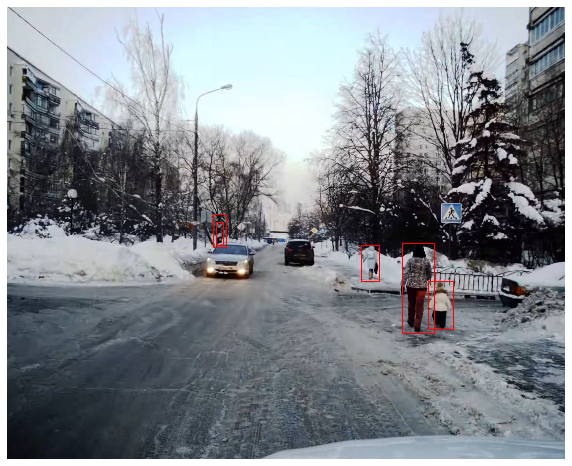

In [120]:
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.axis('off')
ax.imshow(img)

for box, label in zip(pred['boxes'], pred['labels']):
    if label in [1]:
        xy = box[:2]
        w, h = box[2:] - xy
        if np.abs(w.cpu().detach().numpy() - h.cpu().detach().numpy()) > 30:
            rect = patches.Rectangle(xy, w, h,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)